# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


# Variables

In [3]:
img_rows = 28
img_cols = 28
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)
latent_dim = 100
epochs = 100000
batch_size = 32

# Generator

In [4]:
def generator():

    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)


# Discriminator

In [5]:
def discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)


# Download and prepare the dataset

In [6]:
print('Download dataset')
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))


Download dataset
4423680/4422102 [==============================] - 0s 0us/step


# Compile the model

In [7]:
optimizer = Adam(0.0002, 0.5)

disc = discriminator()
disc.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

gen = generator()

z = Input(shape=(latent_dim,))
img = gen(z)

disc.trainable = False

validity = disc(img)

combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


W1011 18:54:31.839459 139802769958720 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1011 18:54:31.840518 139802769958720 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1011 18:54:31.848928 139802769958720 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1011 18:54:31.893636 139802769958720 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1011 18:54:31.897158 139802769958720 de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
__________

# Train

In [8]:
for epoch in range(epochs):

    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    gen_imgs = gen.predict(noise)

    d_loss_real = disc.train_on_batch(imgs, valid)
    d_loss_fake = disc.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    g_loss = combined.train_on_batch(noise, valid)


/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


# Fianally generate pictures

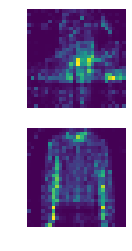

In [9]:
noise = np.random.normal(0, 1, (2, latent_dim))
gen_imgs = gen.predict(noise)

gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(2)
cnt = 0
for i in range(0,2):
    axs[i].imshow(gen_imgs[cnt, :,:,0]) # cmap ='gray'
    axs[i].axis('off')
    cnt += 1

plt.show()
plt.close()